In [72]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [74]:
csv_path = "/content/drive/MyDrive/Tesla Stock Data/TSLA.csv"
df = pd.read_csv(csv_path)

In [75]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [76]:
def check_df(dataframe, record_number=5):
  print(f"""
----- Shape -----
{dataframe.shape}
----- Types -----
{dataframe.dtypes}
----- Head -----
{dataframe.head(record_number)}
----- Tail -----
{dataframe.tail(record_number)}
----- NA -----
{dataframe.isnull().sum()}
----- Quantiles -----
{dataframe.quantile([0,0.05,0.50,0.95,0.99,1]).T}
""")

In [77]:
check_df(df)


----- Shape -----
(2416, 7)
----- Types -----
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
----- Head -----
         Date       Open   High        Low      Close  Adj Close    Volume
0  2010-06-29  19.000000  25.00  17.540001  23.889999  23.889999  18766300
1  2010-06-30  25.790001  30.42  23.299999  23.830000  23.830000  17187100
2  2010-07-01  25.000000  25.92  20.270000  21.959999  21.959999   8218800
3  2010-07-02  23.000000  23.10  18.709999  19.200001  19.200001   5139800
4  2010-07-06  20.000000  20.00  15.830000  16.110001  16.110001   6866900
----- Tail -----
            Date        Open        High         Low       Close   Adj Close  \
2411  2020-01-28  568.489990  576.809998  558.080017  566.900024  566.900024   
2412  2020-01-29  575.690002  589.799988  567.429993  580.989990  580.989990   
2413  2020-01-30  632.419983  650.880005  618.000000  640.809998  64

In [78]:
df["Date"] = pd.to_datetime(df["Date"])

In [79]:
tesla_df = df[["Date","Close"]]

In [80]:
tesla_df.head()

,Date,Close
0,2010-06-29,23.889999
1,2010-06-30,23.830000
2,2010-07-01,21.959999
3,2010-07-02,19.200001
4,2010-07-06,16.110001


In [81]:
print("Minimum Tarih:", tesla_df["Date"].min())
print("Maksimum Tarih:", tesla_df["Date"].max())

Minimum Tarih: 2010-06-29 00:00:00
Maksimum Tarih: 2020-02-03 00:00:00


In [82]:
tesla_df.index = tesla_df["Date"]
tesla_df

,Date,Close
Date,,
2010-06-29,2010-06-29,23.889999
2010-06-30,2010-06-30,23.830000
2010-07-01,2010-07-01,21.959999
2010-07-02,2010-07-02,19.200001
2010-07-06,2010-07-06,16.110001
...,...,...
2020-01-28,2020-01-28,566.900024
2020-01-29,2020-01-29,580.989990
2020-01-30,2020-01-30,640.809998


In [83]:
tesla_df = tesla_df.drop(["Date"],axis=1)
tesla_df

,Close
Date,
2010-06-29,23.889999
2010-06-30,23.830000
2010-07-01,21.959999
2010-07-02,19.200001
2010-07-06,16.110001
...,...
2020-01-28,566.900024
2020-01-29,580.989990
2020-01-30,640.809998


In [84]:
result_df = tesla_df.copy()

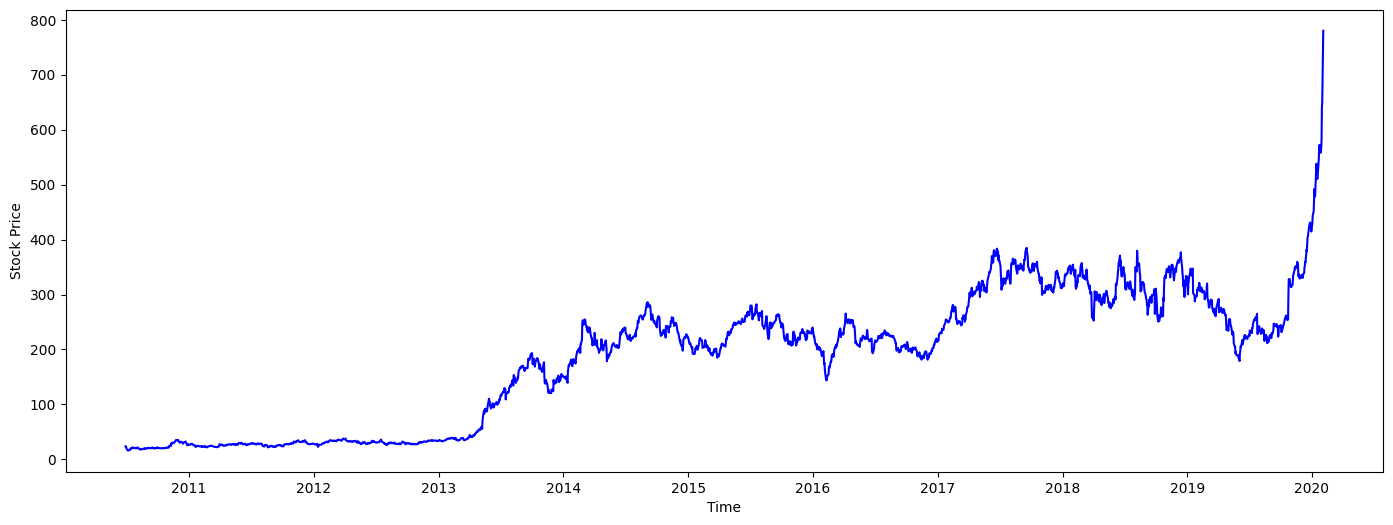

In [85]:
plt.figure(figsize=(17,6))
plt.plot(tesla_df['Close'], color = 'blue')
plt.ylabel('Stock Price')
plt.xlabel('Time')
plt.show()

In [86]:
tesla_df = tesla_df.values

In [87]:
tesla_df[0:5]

array([[23.889999],
       [23.83    ],
       [21.959999],
       [19.200001],
       [16.110001]])

In [88]:
tesla_df = tesla_df.astype('float32')

In [89]:
def split_data(dataframe, test_size):
  pos = int(round(len(dataframe)*(1-test_size)))
  train = dataframe[:pos]
  test = dataframe[pos:]

  return train, test, pos

In [90]:
train, test, pos = split_data(tesla_df,0.2)
print(train.shape, test.shape)

(1933, 1) (483, 1)


In [91]:
scaler_train = MinMaxScaler(feature_range = (0,1))
train = scaler_train.fit_transform(train)

scaler_test = MinMaxScaler(feature_range = (0,1))
test = scaler_test.fit_transform(test)

In [92]:
train[0:5]

array([[0.02191224],
       [0.02174973],
       [0.01668472],
       [0.0092091 ],
       [0.00083966]], dtype=float32)

In [93]:
test[0:5]

array([[0.25685903],
       [0.24829045],
       [0.25511202],
       [0.24978784],
       [0.2465767 ]], dtype=float32)

In [94]:
def create_features(data, lookback):
  X, Y = [], []
  for i in range(lookback, len(data)):
    X.append(data[i-lookback:i,0])
    Y.append(data[i,0])

  return np.array(X), np.array(Y)


In [95]:
lookback = 20

In [96]:
X_train, y_train = create_features(train, lookback)

X_test, y_test = create_features(test, lookback)

In [97]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1913, 20) (1913,) (463, 20) (463,)


In [98]:
X_train[:5]

array([[0.02191224, 0.02174973, 0.01668472, 0.0092091 , 0.00083966,
        0.        , 0.00449621, 0.00433369, 0.0033857 , 0.00633803,
        0.01094258, 0.011078  , 0.01310942, 0.0165493 , 0.01218851,
        0.01197183, 0.01408451, 0.01486999, 0.01394908, 0.01286566],
       [0.02174973, 0.01668472, 0.0092091 , 0.00083966, 0.        ,
        0.00449621, 0.00433369, 0.0033857 , 0.00633803, 0.01094258,
        0.011078  , 0.01310942, 0.0165493 , 0.01218851, 0.01197183,
        0.01408451, 0.01486999, 0.01394908, 0.01286566, 0.01332611],
       [0.01668472, 0.0092091 , 0.00083966, 0.        , 0.00449621,
        0.00433369, 0.0033857 , 0.00633803, 0.01094258, 0.011078  ,
        0.01310942, 0.0165493 , 0.01218851, 0.01197183, 0.01408451,
        0.01486999, 0.01394908, 0.01286566, 0.01332611, 0.01232395],
       [0.0092091 , 0.00083966, 0.        , 0.00449621, 0.00433369,
        0.0033857 , 0.00633803, 0.01094258, 0.011078  , 0.01310942,
        0.0165493 , 0.01218851, 0.01197183, 0

In [99]:
y_train[:5]

array([0.01332611, 0.01232395, 0.01121344, 0.01386782, 0.01665764],
      dtype=float32)

In [100]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1913, 1, 20) (1913, 1) (463, 1, 20) (463, 1)


In [101]:
model = Sequential()
model.add(LSTM(units = 50,
               activation = "relu",
               input_shape = (X_train.shape[1], lookback)))
model.add(Dropout(0.2))
model.add(Dense(1))

In [102]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                14200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 14,251
Trainable params: 14,251
Non-trainable params: 0
_________________________________________________________________


In [103]:
model.compile(loss="mean_squared_error", optimizer="adam")

callbacks = [EarlyStopping(monitor="val_loss", patience=3, verbose=1, mode="min"),
             ModelCheckpoint(filepath="mymodel.h5", monitor="val_loss", mode="min",
                             save_best_only=True, save_weights_only=False, verbose=1)]

In [104]:
history = model.fit(x=X_train,
                    y=y_train,
                    epochs=100,
                    batch_size=20,
                    validation_data=(X_test,y_test),
                    callbacks=callbacks,
                    shuffle=False)

Epoch 1/100
87/96 [==========================>...] - ETA: 0s - loss: 0.0076
Epoch 1: val_loss improved from inf to 0.00440, saving model to mymodel.h5
96/96 [==============================] - 2s 6ms/step - loss: 0.0082 - val_loss: 0.0044
Epoch 2/100
87/96 [==========================>...] - ETA: 0s - loss: 0.0057
Epoch 2: val_loss improved from 0.00440 to 0.00342, saving model to mymodel.h5
96/96 [==============================] - 0s 3ms/step - loss: 0.0063 - val_loss: 0.0034
Epoch 3/100
90/96 [===========================>..] - ETA: 0s - loss: 0.0046
Epoch 3: val_loss improved from 0.00342 to 0.00298, saving model to mymodel.h5
96/96 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0030
Epoch 4/100
87/96 [==========================>...] - ETA: 0s - loss: 0.0036
Epoch 4: val_loss improved from 0.00298 to 0.00289, saving model to mymodel.h5
96/96 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0029
Epoch 5/100
85/96 [=================

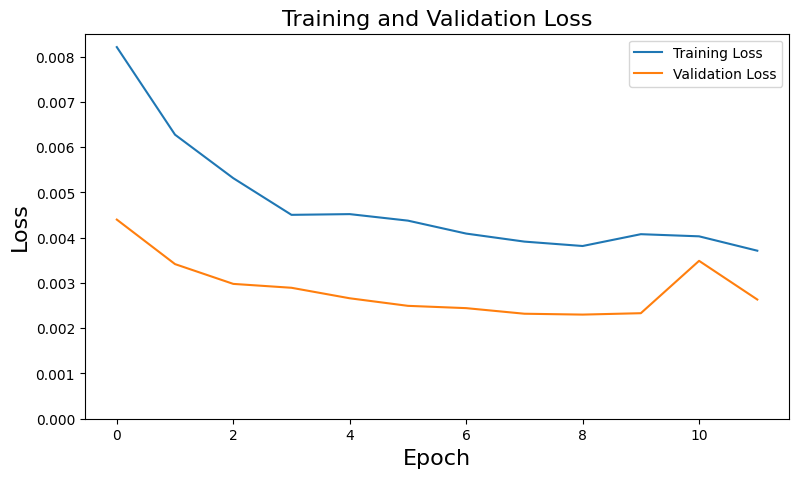

In [105]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title("Training and Validation Loss", fontsize=16)
plt.show()

In [106]:
loss = model.evaluate(X_test, y_test, batch_size=20)
print(f"\nTest loss: {(100.0 * loss):.1f}%")

24/24 [==============================] - 0s 2ms/step - loss: 0.0026

Test loss: 0.3%


In [107]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

15/15 [==============================] - 0s 2ms/step


In [108]:
train_predict = scaler_train.inverse_transform(train_predict)
test_predict = scaler_test.inverse_transform(test_predict)

y_train = scaler_train.inverse_transform(y_train)
y_test = scaler_test.inverse_transform(y_test)

In [109]:
train_rmse = np.sqrt(mean_squared_error(y_train,train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test,test_predict))

In [110]:
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 12.915032386779785
Test RMSE: 30.845056533813477


In [111]:
train_prediction_df = result_df[lookback:pos]
train_prediction_df["predicted"] = train_predict
train_prediction_df.head()

,Close,predicted
Date,,
2010-07-28,20.719999,33.469177
2010-07-29,20.350000,33.495991
2010-07-30,19.940001,33.513634
2010-08-02,20.920000,33.498230
2010-08-03,21.950001,33.475697


In [112]:
test_prediction_df = result_df[pos+lookback:]
test_prediction_df["Predicted"] = test_predict
test_prediction_df.head()

,Close,Predicted
Date,,
2018-04-03,267.529999,323.791687
2018-04-04,286.940002,319.479492
2018-04-05,305.720001,317.009918
2018-04-06,299.299988,317.490173
2018-04-09,289.660004,317.650787


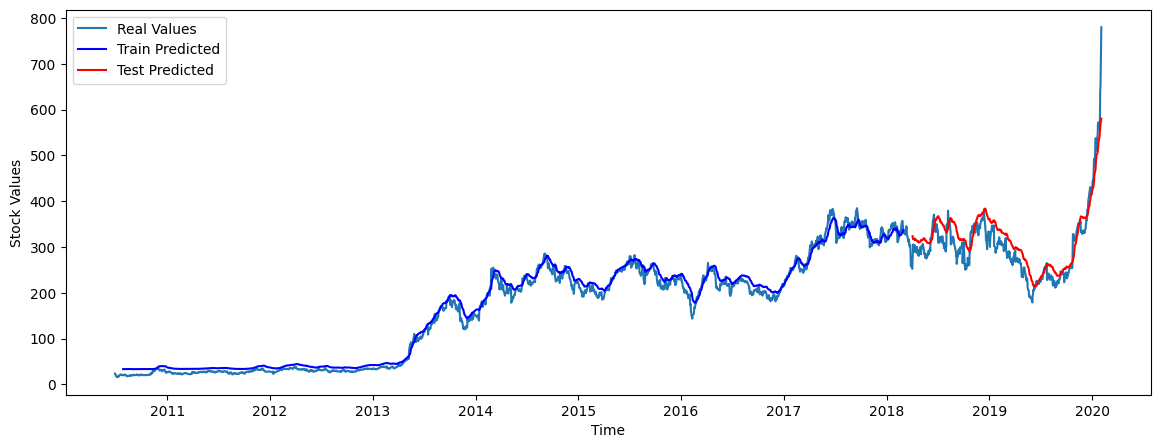

In [113]:
plt.figure(figsize=(14,5))
plt.plot(result_df, label = "Real Values")
plt.plot(train_prediction_df["predicted"], color = "blue", label = "Train Predicted")
plt.plot(test_prediction_df["Predicted"], color="red", label = "Test Predicted")
plt.xlabel("Time")
plt.ylabel("Stock Values")
plt.legend()
plt.show()